# Making Features Discrete
In previous weeks we have imputed values and made new variables using the `pandas.cut` function to define how to make a single attribute discrete. In this module, let's instead use clustering to convert one or more features into discrete, categorical features (integers). 

The process will be simple:
- Choose a subset of features from the dataset to cluster upon
- Cluster the features assuming according to a given algorithm
- Replace the features with their discrete cluster labels as a form of discretization
- Perform classification using the new feature from the dataset

In this notebook, we will investigate simple clustering methods for making the clusters discrete: kmeans, hierarchical agglomerative clustering, and DBSCAN. The dataset we will use comes from our titanic dataset that we have used in the past.

In [2]:
import pandas as pd
df = pd.read_csv('data/titanic.csv') # read in the csv file
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# load the Titanic dataset
import pandas as pd
import numpy as np

df = pd.read_csv('data/titanic.csv') # read in the csv file

# 1. Remove attributes that just arent useful for us
del df['PassengerId']
del df['Name']
del df['Cabin']
del df['Ticket']
del df['Embarked']

# 2. Impute some missing values, grouped by their Pclass and SibSp numbers
df_grouped = df.groupby(by=['Pclass','SibSp'])
# now use this grouping to fill the data set in each group, then transform back
df_imputed = df_grouped.transform(lambda grp: grp.fillna(grp.median()))
df_imputed[['Pclass','SibSp','Sex']] = df[['Pclass','SibSp','Sex']]

# 3. drop rows that still had missing values after grouped imputation
df_imputed.dropna(inplace=True)
# 4. replace Sex with integers
df_imputed.Sex = df_imputed.Sex.replace(to_replace={'male':0, 'female':1})

# 5. Rearrange the columns
df_imputed = df_imputed[['Survived','Age','Sex','Parch','SibSp','Pclass','Fare']]

# 6. normalize distances for clustering contiuous variables
# dont want distance to be trumped by dynamic range of age or fare, distance between fare may be larger than
# distance between sibsp
df_imputed[['Age','Fare']] = (df_imputed[['Age','Fare']] - df_imputed[['Age','Fare']].mean()) / df_imputed[['Age','Fare']] .std()

print df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 884 entries, 0 to 890
Data columns (total 7 columns):
Survived    884 non-null int64
Age         884 non-null float64
Sex         884 non-null int64
Parch       884 non-null int64
SibSp       884 non-null int64
Pclass      884 non-null int64
Fare        884 non-null float64
dtypes: float64(2), int64(5)
memory usage: 55.2 KB
None


For this dataset, it probably makes sense to try and cluster `PClass` and `Fare` together because they have similar information and can likely be combined. It is unclear exactly where to make the classes discrete and how many levels we should make, so we will try a few different parameterizations to investigate this.

It also might make sense to make the `Age`, `Parch`, and `SibSp` variables into a single discrete variable representing clusters of families. Again, we will need to try different parameterizations (numbers of cluster and the algorithm for clustering).

##Baseline Classification Performance
Let's start by performing 10 fold cross validation and using the raw features in a Random Forest classifer. Let's get the average accuracy of classifying whther a person survives or does not from the Titanic.

In [4]:
from sklearn.cross_validation import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

y = df_imputed['Survived']
X = df_imputed[['Age','Sex','Parch','SibSp','Pclass','Fare']]
cv = StratifiedKFold(y,n_folds=10)

clf = RandomForestClassifier(n_estimators=150,random_state=1)

acc = cross_val_score(clf,X,y=y,cv=cv)

print "Average accuracy = ", acc.mean()*100, "+-", acc.std()*100

Average accuracy =  80.6843434343 +- 4.93898918525


Okay, now let's start with a bit of feature engineering. We will start by using kmeans on `PClass` and `Fare` together.

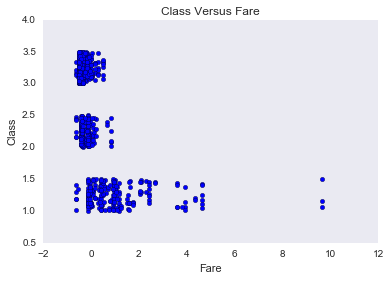

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_palette("Set1", 8, .75)

%matplotlib inline

X1 = df_imputed[['Pclass','Fare']].values

plt.scatter(X1[:, 1], X1[:, 0] + np.random.random(X1[:, 1].shape)/2, 
             s=20)
plt.xlabel('Fare'), plt.ylabel('Class')
plt.grid()
plt.title('Class Versus Fare')
plt.show()

In [6]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

X1 = df_imputed[['Pclass','Fare']]

cls = KMeans(n_clusters=8, init='k-means++', random_state=1)
cls.fit(X1) # no class labels
newfeature = cls.labels_ # the labels from kmeans clustering

y = df_imputed['Survived']
X = df_imputed[['Age','Sex','Parch','SibSp']]
X = np.column_stack((X,pd.get_dummies(newfeature))) # replace class and fare with new features
# stack onto X, the pd.get_dummies grabs us one hot encoding

acc = cross_val_score(clf,X,y=y,cv=cv)
print "Average accuracy (with kmeans for class/fare)= ", acc.mean()*100, "+-", acc.std()*100

Average accuracy (with kmeans for class/fare)=  80.2272727273 +- 4.26885704795


So it seems that the average accuracy of the folds has stayed about the same, but the deviation from the mean has been considerably decreased. Let's now try adding in different discretization of the features.

In [11]:
# take a look at family now by itself

from sklearn.cluster import KMeans
import numpy as np

X2 = df_imputed[['Age','Parch','SibSp']]

cls = KMeans(n_clusters=8, init='k-means++',random_state=1)
cls.fit(X2)
newfeature = cls.labels_ # the labels from kmeans clustering

y = df_imputed['Survived']
X = df_imputed[['Sex','Pclass','Fare']]
X = np.column_stack((X,pd.get_dummies(newfeature)))

acc = cross_val_score(clf,X,y=y,cv=cv)

print "Average accuracy (with kmeans for Age/Family)= ", acc.mean()*100, "+-", acc.std()*100

Average accuracy (with kmeans for Age/Family)=  80.2095959596 +- 3.09650023292


This discretization actually helps increase the accuracy on average, but not really helping in the lowering of the deviation from the mean. What if we combine the different clusterings?

In [12]:
# get the first clustering
cls_fare = KMeans(n_clusters=8, init='k-means++',random_state=1)

cls_fare.fit(X1)
newfeature_fare = cls_fare.labels_ # the labels from kmeans clustering

# append on the second clustering
cls_fam = KMeans(n_clusters=8, init='k-means++',random_state=1)
cls_fam.fit(X2)
newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

y = df_imputed['Survived']
X = df_imputed[['Sex']]
X = np.column_stack((X,pd.get_dummies(newfeature_fare),pd.get_dummies(newfeature_fam))) # stack multiple features

acc = cross_val_score(clf,X,y=y,cv=cv)

print "Average accuracy = ", acc.mean()*100, "+-", acc.std()*100

Average accuracy =  80.9924242424 +- 3.73850054676


It seems this is not quite as accurate, but we still need to vary the parameters and see what works.

In [13]:
X1 = df_imputed[['Pclass','Fare']]
X2 = df_imputed[['Age','Parch','SibSp']]

params = []
for n_fare in range(4,10):
    for n_fam in range(16,19):
        # get the first clustering
        cls_fare = KMeans(n_clusters=n_fare, init='k-means++',random_state=1)
        cls_fare.fit(X1)
        newfeature_fare = cls_fare.labels_ # the labels from kmeans clustering

        # append on the second clustering
        cls_fam = KMeans(n_clusters=n_fam, init='k-means++',random_state=1)
        cls_fam.fit(X2)
        newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

        y = df_imputed['Survived']
        X = df_imputed[['Sex']]
        X = np.column_stack((X,pd.get_dummies(newfeature_fare),pd.get_dummies(newfeature_fam)))

        acc = cross_val_score(clf,X,y=y,cv=cv)
        params.append((n_fare,n_fam,acc.mean()*100,acc.std()*100)) # save state

        print "Clusters",n_fare,n_fam,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100

Clusters 4 16 Average accuracy =  81.4621212121 +- 3.88910943229
Clusters 4 17 Average accuracy =  82.4772727273 +- 3.70678256249
Clusters 4 18 Average accuracy =  80.6691919192 +- 3.5440954329
Clusters 5 16 Average accuracy =  81.5732323232 +- 3.76438928935
Clusters 5 17 Average accuracy =  82.25 +- 3.06161120442
Clusters 5 18 Average accuracy =  80.4393939394 +- 3.44746823642
Clusters 6 16 Average accuracy =  80.8939393939 +- 3.4217907853
Clusters 6 17 Average accuracy =  81.797979798 +- 3.19804663751
Clusters 6 18 Average accuracy =  80.4368686869 +- 2.51961618462
Clusters 7 16 Average accuracy =  81.2373737374 +- 3.74606551411
Clusters 7 17 Average accuracy =  82.5883838384 +- 3.57868912672
Clusters 7 18 Average accuracy =  80.3232323232 +- 3.23797643266
Clusters 8 16 Average accuracy =  80.5580808081 +- 3.93478508562
Clusters 8 17 Average accuracy =  81.7954545455 +- 3.66670579744
Clusters 8 18 Average accuracy =  79.6439393939 +- 3.36146018875
Clusters 9 16 Average accuracy =  80

It seems that about the best we can do with these new discretization methods is around 82%. All the models are within one standard deviation of each other, so most clustering in this range are pretty reasonable. 

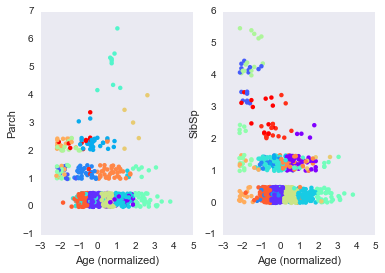

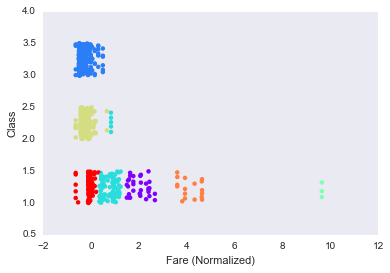

In [14]:
n_fare=7
d_fam=17

X1 = df_imputed[['Pclass','Fare']]
X2 = df_imputed[['Age','Parch','SibSp']]

cls_fare = KMeans(n_clusters=n_fare, init='k-means++',random_state=1)
cls_fare.fit(X1)
newfeature_fare = cls_fare.labels_ # the labels from kmeans clustering

# append on the second clustering
cls_fam = KMeans(n_clusters=n_fam, init='k-means++',random_state=1)
cls_fam.fit(X2)
newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

plt.figure()
plt.subplot(1,2,1)
X2=X2.values
plt.scatter(X2[:, 0], X2[:, 1]+np.random.random(X2[:, 1].shape)/2, c=newfeature_fam, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('Age (normalized)'), plt.ylabel('Parch')
plt.grid()

plt.subplot(1,2,2)
plt.scatter(X2[:, 0], X2[:, 2]+np.random.random(X2[:, 1].shape)/2, c=newfeature_fam, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('Age (normalized)'), plt.ylabel('SibSp')
plt.grid()

X1=X1.values
plt.figure()
plt.scatter(X1[:, 1], X1[:, 0]+np.random.random(X1[:, 0].shape)/2, c=newfeature_fare, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('Fare (Normalized)'), plt.ylabel('Class')
plt.grid()

Let's see if we can make things simpler by only clustering on one set of attributes.

In [15]:

params = []
for n_fam in range(15,20):

    # append on the clustering
    cls_fam = KMeans(n_clusters=n_fam, init='k-means++',random_state=1)
    cls_fam.fit(X2)
    newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

    y = df_imputed['Survived']
    X = df_imputed[['Sex','Pclass','Fare']]
    X = np.column_stack((X,pd.get_dummies(newfeature_fam)))

    acc = cross_val_score(clf,X,y=y,cv=cv)
    params.append((n_fare,n_fam,acc.mean()*100,acc.std()*100)) # save state

    print "Clusters",n_fam,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100

Clusters 15 Average accuracy =  80.3409090909 +- 4.43877694774
Clusters 16 Average accuracy =  80.4545454545 +- 3.76721637179
Clusters 17 Average accuracy =  80.7878787879 +- 3.02353621573
Clusters 18 Average accuracy =  79.3181818182 +- 3.70109335622
Clusters 19 Average accuracy =  80.7878787879 +- 3.23178657161


So it seems that the accuracy is fairly stagnant, but has a tight standard deviation. Now, let's also try to replace features using some slightly different clustering algorithms and see what works best for classification.

In [16]:
from sklearn.cluster import AgglomerativeClustering

X1 = df_imputed[['Pclass','Fare']]

params = []
for link in ['ward', 'complete', 'average']:
    for n_fam in range(13,20):

        # append on the clustering
        cls_fam = AgglomerativeClustering(n_clusters=n_fam, linkage=link)
        cls_fam.fit(X2)
        newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

        y = df_imputed['Survived']
        X = df_imputed[['Sex','Pclass','Fare']]
        X = np.column_stack((X,pd.get_dummies(newfeature_fam)))

        acc = cross_val_score(clf,X,y=y,cv=cv)
        params.append((n_fare,n_fam,acc.mean()*100,acc.std()*100)) # save state

        print "C=",n_fam,link,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100

C= 13 ward Average accuracy =  81.0075757576 +- 2.90158987517
C= 14 ward Average accuracy =  80.2196969697 +- 3.37702936981
C= 15 ward Average accuracy =  80.1060606061 +- 3.41669186311
C= 16 ward Average accuracy =  80.2196969697 +- 3.37534834973
C= 17 ward Average accuracy =  80.3333333333 +- 3.2146930813
C= 18 ward Average accuracy =  80.2171717172 +- 3.16030485602
C= 19 ward Average accuracy =  80.2196969697 +- 3.26029660861
C= 13 complete Average accuracy =  79.9949494949 +- 3.97976593332
C= 14 complete Average accuracy =  80.904040404 +- 3.90229226349
C= 15 complete Average accuracy =  80.5631313131 +- 3.58539707515
C= 16 complete Average accuracy =  80.6818181818 +- 4.3167195823
C= 17 complete Average accuracy =  80.7904040404 +- 3.82951943595
C= 18 complete Average accuracy =  80.4570707071 +- 4.23326708335
C= 19 complete Average accuracy =  80.6818181818 +- 4.3167195823
C= 13 average Average accuracy =  80.7929292929 +- 5.16410375131
C= 14 average Average accuracy =  80.906565

Again, all fairly good performances using different types of linkage and also different numbers of clusters. Let's now try DBSCAN.

In [17]:
from sklearn.cluster import DBSCAN

params = []
for eps in [0.1, 0.125, 0.15]:
    for mpts in range(5,8):

        # append on the clustering
        cls_fam = DBSCAN(eps=eps, min_samples=mpts,random_state=1)
        cls_fam.fit(X2)
        newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

        y = df_imputed['Survived']
        X = df_imputed[['Sex','Pclass','Fare']]
        X = np.column_stack((X,pd.get_dummies(newfeature_fam)))

        acc = cross_val_score(clf,X,y=y,cv=cv)
        params.append((n_fare,n_fam,acc.mean()*100,acc.std()*100)) # save state

        print eps,mpts,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100

/Users/patrickcorynichols/anaconda/lib/python2.7/site-packages/sklearn/cluster/dbscan_.py:116: DeprecationWarning: The parameter random_state is deprecated in 0.16 and will be removed in version 0.18. DBSCAN is deterministic except for rare border cases.
  category=DeprecationWarning)


0.1 5 Average accuracy =  80.9141414141 +- 5.62875105915


/Users/patrickcorynichols/anaconda/lib/python2.7/site-packages/sklearn/cluster/dbscan_.py:116: DeprecationWarning: The parameter random_state is deprecated in 0.16 and will be removed in version 0.18. DBSCAN is deterministic except for rare border cases.
  category=DeprecationWarning)


0.1 6 Average accuracy =  81.4772727273 +- 5.40701619663


/Users/patrickcorynichols/anaconda/lib/python2.7/site-packages/sklearn/cluster/dbscan_.py:116: DeprecationWarning: The parameter random_state is deprecated in 0.16 and will be removed in version 0.18. DBSCAN is deterministic except for rare border cases.
  category=DeprecationWarning)


0.1 7 Average accuracy =  81.1388888889 +- 5.83084526501


/Users/patrickcorynichols/anaconda/lib/python2.7/site-packages/sklearn/cluster/dbscan_.py:116: DeprecationWarning: The parameter random_state is deprecated in 0.16 and will be removed in version 0.18. DBSCAN is deterministic except for rare border cases.
  category=DeprecationWarning)


0.125 5 Average accuracy =  80.5757575758 +- 5.69839109355


/Users/patrickcorynichols/anaconda/lib/python2.7/site-packages/sklearn/cluster/dbscan_.py:116: DeprecationWarning: The parameter random_state is deprecated in 0.16 and will be removed in version 0.18. DBSCAN is deterministic except for rare border cases.
  category=DeprecationWarning)


0.125 6 Average accuracy =  81.5883838384 +- 5.04688569808


/Users/patrickcorynichols/anaconda/lib/python2.7/site-packages/sklearn/cluster/dbscan_.py:116: DeprecationWarning: The parameter random_state is deprecated in 0.16 and will be removed in version 0.18. DBSCAN is deterministic except for rare border cases.
  category=DeprecationWarning)


0.125 7 Average accuracy =  81.1388888889 +- 5.83084526501


/Users/patrickcorynichols/anaconda/lib/python2.7/site-packages/sklearn/cluster/dbscan_.py:116: DeprecationWarning: The parameter random_state is deprecated in 0.16 and will be removed in version 0.18. DBSCAN is deterministic except for rare border cases.
  category=DeprecationWarning)


0.15 5 Average accuracy =  80.5757575758 +- 5.69839109355


/Users/patrickcorynichols/anaconda/lib/python2.7/site-packages/sklearn/cluster/dbscan_.py:116: DeprecationWarning: The parameter random_state is deprecated in 0.16 and will be removed in version 0.18. DBSCAN is deterministic except for rare border cases.
  category=DeprecationWarning)


0.15 6 Average accuracy =  81.5883838384 +- 5.04688569808


/Users/patrickcorynichols/anaconda/lib/python2.7/site-packages/sklearn/cluster/dbscan_.py:116: DeprecationWarning: The parameter random_state is deprecated in 0.16 and will be removed in version 0.18. DBSCAN is deterministic except for rare border cases.
  category=DeprecationWarning)


0.15 7 Average accuracy =  81.1388888889 +- 5.83084526501


It seems that DBSCAN has good clusterings for this dataset that are able to capture some of the nuances for the attributes. Although this is not spatial data, it is interesting that contiguous clustering helps discretize the data a bit (for a small range of eps and minpts). Even so, the center based clustering also tend to do well.

##Visualizing different clusters
Now lets take the best performers from each dataset and show the clustering that they found in the data.

/Users/patrickcorynichols/anaconda/lib/python2.7/site-packages/sklearn/cluster/dbscan_.py:116: DeprecationWarning: The parameter random_state is deprecated in 0.16 and will be removed in version 0.18. DBSCAN is deterministic except for rare border cases.
  category=DeprecationWarning)


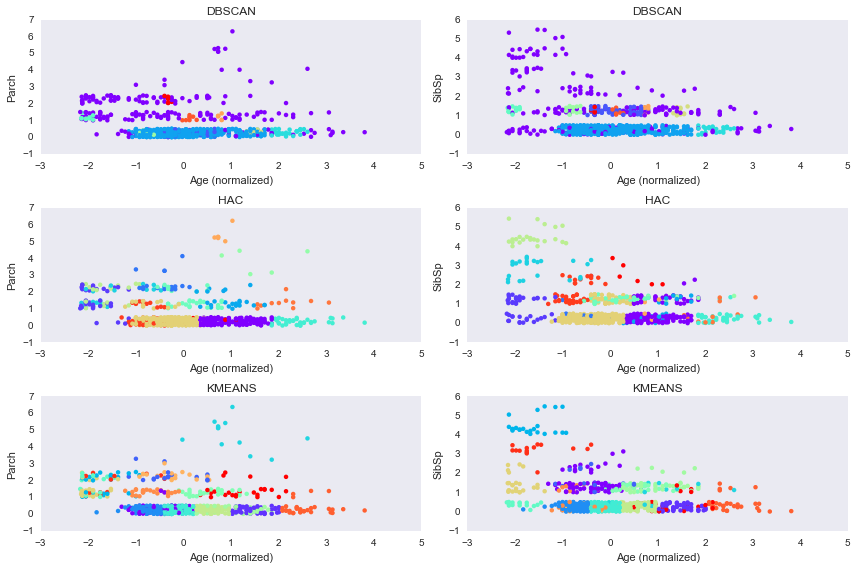

In [18]:


data = X2

cls = DBSCAN(eps=0.125, min_samples=6,random_state=1)
cls.fit(data)
dbs_labels = cls.labels_ 

cls = AgglomerativeClustering(n_clusters=14, linkage='complete')
cls.fit(data)
hac_labels = cls.labels_ 

cls = KMeans(n_clusters=17, random_state=1)
cls.fit(data)
kmn_labels = cls.labels_

fig = plt.figure(figsize=(12,8))
title = ['DBSCAN','HAC','KMEANS']

for i,l in enumerate([dbs_labels,hac_labels,kmn_labels]):
    
    plt.subplot(3,2,2*i+1)
    plt.scatter(data[:, 0], data[:, 1]+np.random.random(data[:, 1].shape)/2, c=l, cmap=plt.cm.rainbow, s=20, linewidths=0)
    plt.xlabel('Age (normalized)'), plt.ylabel('Parch')
    plt.grid()
    plt.title(title[i])
    
    plt.subplot(3,2,2*i+2)
    plt.scatter(data[:, 0], data[:, 2]+np.random.random(data[:, 1].shape)/2, c=l, cmap=plt.cm.rainbow, s=20, linewidths=0)
    plt.xlabel('Age (normalized)'), plt.ylabel('SibSp')
    plt.grid()
    plt.title(title[i])
    
    


plt.tight_layout()
plt.show()